In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.constants as sc
from scipy import stats
import matplotlib.ticker as ticker
import csv
import matplotlib.pyplot as plt
import dielectric as d

In [2]:
# data_dir= "Data_Rodrigo_09-22-2020.csv"
data_dir= "Corrected Data.csv"

In [3]:
df = pd.read_csv(data_dir)
df['Corrected Phase'] *= -1
# df.to_csv("Corrected Data.csv", index =False)
df.head()

,Torr,Zero,Current,Phase,Corrected Phase
0,2,50.5,14,55.0,4.5
1,2,50.5,24,59.0,8.5
2,2,50.5,34,62.0,11.5
3,2,50.5,44,65.0,14.5
4,2,50.5,54,68.0,17.5


In [4]:
df.Torr.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

In [5]:
df.query( 'Torr ==2')['Corrected Phase']

0     4.5
1     8.5
2    11.5
3    14.5
4    17.5
Name: Corrected Phase, dtype: float64

In [6]:
sc.epsilon_0, sc.m_e, sc.e # C^2*s^2*kg^-1*m^-3,   kg,   C

(8.8541878128e-12, 9.1093837015e-31, 1.602176634e-19)

In [7]:
freq = 9.049E9
slope, inter = d.k()
freq, slope, inter

(9049000000.0, 0.005013144466198246, 1.0395192023067297)

In [8]:
def make_e_density(array, freq, slope, inter):
    k = inter + slope*array
    return -1.11714E18*(1-k)

In [9]:
# def make_e_density(array, freq, slope, inter):
#     k = inter + slope*array
#     omega = freq*360 # w = 2*Pi*f
#     n = ((sc.epsilon_0*sc.m_e*omega**2)/sc.e) # C^2*s^2*kg^-1*m^-3*kg*rads^2/s^2/C^2 * (1 - (inter + slope* degrees))
#     return n*(1-k)

In [10]:
def add_e_density_to_df(df,freq, slope, inter):
    ed = make_e_density(df['Corrected Phase'], freq, slope, inter)
    df['Electron Density'] = ed
    df['Density err'] = np.zeros(len(df))+5.66821E15

In [11]:
def add_err_(df, label, err):
    df[label] = np.zeros(len(df))+err

In [22]:
add_e_density_to_df(df, freq, slope, inter)
add_err_(df, 'Current err (mA)', 1)# 10 points worth 2mA so half is 2
add_err_(df, 'Pressure err Torr', 2.333)# 1Torr = 3/4cm and each had 1mm err so 4/3 Torr devided by 10 mm per cm
add_err_(df, 'Phase err Deg$^o$', 0.5)

In [23]:
df.head()

,Torr,Zero,Current,Phase,Corrected Phase,Electron Density,Density err,Current err (mA),Pressure err Torr,Phase err Deg$^o$
0,2,50.5,14,55.0,4.5,1.080394e+34,5.668210e+15,1.0,2.333,0.5
1,2,50.5,24,59.0,8.5,2.040745e+34,5.668210e+15,1.0,2.333,0.5
2,2,50.5,34,62.0,11.5,2.761007e+34,5.668210e+15,1.0,2.333,0.5
3,2,50.5,44,65.0,14.5,3.481270e+34,5.668210e+15,1.0,2.333,0.5
4,2,50.5,54,68.0,17.5,4.201533e+34,5.668210e+15,1.0,2.333,0.5


In [29]:
plt.rcParams['axes.grid'] = True
def make_data(df):
    tor = df.Torr.unique()
    fig, ax = plt.subplots(figsize=(15,8))
    plt.title("Electron Density $\eta_e$ vs Current $I$", fontsize=20)
    ax2=ax.twiny()
    for objs in tor:
        by_torr = f'Torr == {objs}'
        data = df.query(by_torr)
#         std = np.std(data['Electron Density'])
#         data['density std'] =  np.zeros(len(data))+std
        data.plot(x = 'Current' , y = 'Electron Density' , xerr = 'Current err (mA)', yerr = 'Density err' ,marker='o', linestyle='', 
                  label = f"Torr = {objs}", stacked=True, ax =ax)
#         data.plot(x = 'Current' , y = 'Phase' , 
#                   label = by_torr, stacked=True, ax =ax2)
#         m, b = np.polyfit(data.Current, data.Phase, 1)
#         ax2.plot(data.Current, m*data.Current + b, label = f'y ={m}x + {b}')
        slope, intercept, r_value, p_value, std_err = stats.linregress(data['Current'], data['Electron Density'])
        ax2.plot(data.Current, slope*data.Current + intercept, label = "y={0:.2e}x + {1:.2e},  R = {2:.3f}".format(slope,intercept,r_value))
        ax.set_ylabel("$\eta_e$ \n x $\\frac{10^{17}}{m^3}$",fontsize=14, rotation=0)
        ax.set_xlabel("Current ($mA$)",fontsize=14)
        ax.get_shared_x_axes().join(ax, ax2)
        ax.ticklabel_format(useOffset=False)
        ax2.legend(loc = 9)
        

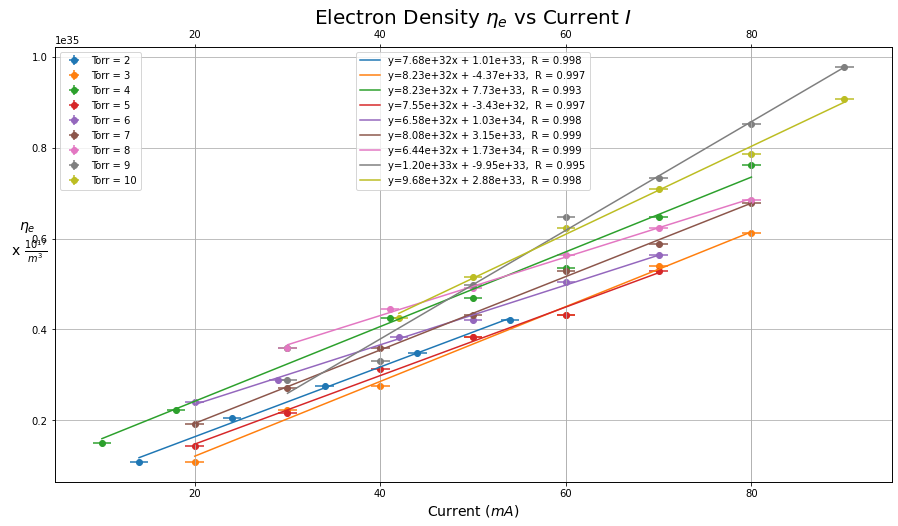

In [30]:
make_data(df)

In [28]:
def make_data2(df):
    cur = df.Current.unique()
    fig, ax = plt.subplots(figsize=(15,8))
    plt.title("Electron Density $\\frac{\#^s}{m^3}$ vs Pressure ($Torr$) for $He_{gas}$ ", fontsize=20)
    ax2=ax.twiny()
    for objs in range(20,91,10):
        by_cur = f'Current == {objs}'
        data = df.query(by_cur)
        data.plot(x = 'Torr' , y = 'Electron Density' , xerr = 'Pressure err Torr', yerr = 'Density err' ,marker='o', linestyle='', 
                  label = f"Current = {objs}", stacked=True, ax =ax)
#         data.plot(x = 'Current' , y = 'Phase' , 
#                   label = by_torr, stacked=True, ax =ax2)
#         m, b = np.polyfit(data.Current, data.Phase, 1)
#         ax2.plot(data.Current, m*data.Current + b, label = f'y ={m}x + {b}')
        slope, intercept, r_value, p_value, std_err = stats.linregress(data['Torr'], data['Electron Density'])
        ax2.plot(data.Torr, slope*data.Torr + intercept, label = "y={0:.2e}x + {1:.2e},  R = {2:.3f}".format(slope,intercept,r_value))
        ax.set_ylabel("Electron Density   x$10^{17} * m^-3$",fontsize=14)
        ax.set_xlabel("Pressure ($Torr$)",fontsize=14)
        ax.get_shared_x_axes().join(ax, ax2)
        ax.ticklabel_format(useOffset=False)
        ax2.legend(loc = 9)

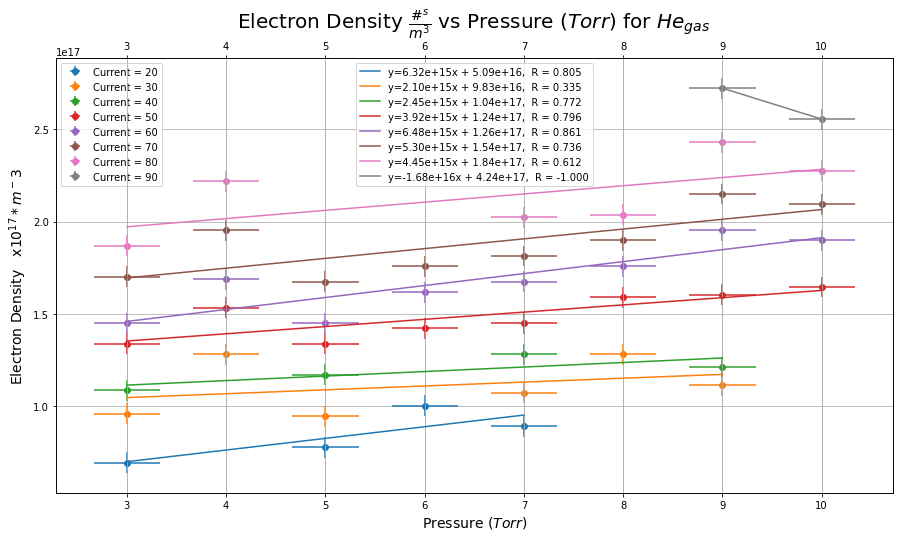

In [17]:
make_data2(df)

Text(0.75, 0.75, 'y=9.73e+15x + 9.19e+16,  R = 0.525')

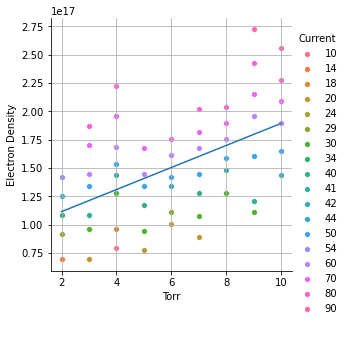

In [18]:
sns.pairplot(x_vars=["Torr"], y_vars=["Electron Density"], data=df, hue="Current", height=4)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Torr'], df['Electron Density'])
plt.plot(df.Torr, slope*df.Torr + intercept, label = "y={0:.2e}x + {1:.2e},  R = {2:.3f}".format(slope,intercept,r_value))
plt.annotate("y={0:.2e}x + {1:.2e},  R = {2:.3f}".format(slope,intercept,r_value),(0.75,0.75))

Text(0.75, 0.75, 'y=2.15e+15x + 4.25e+16,  R = 0.946')

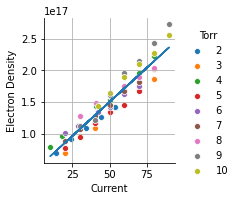

In [19]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Current'], df['Electron Density'])
sns.pairplot(x_vars=["Current"], y_vars=["Electron Density"], data=df, hue="Torr")
plt.plot(df.Current, slope*df.Current + intercept, label = "y={0:.2e}x + {1:.2e},  R = {2:.3f}".format(slope,intercept,r_value))
plt.annotate("y={0:.2e}x + {1:.2e},  R = {2:.3f}".format(slope,intercept,r_value),(0.75,0.75))

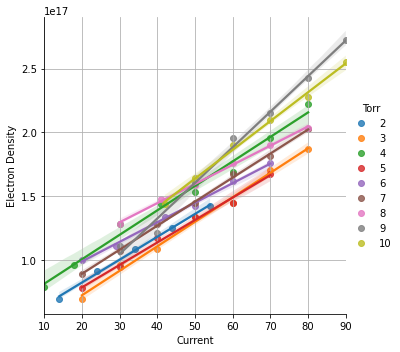

In [20]:
sns.lmplot(x="Current", y="Electron Density", data=df, hue="Torr");

2149127217772261.2 4.252116147018051e+16 0.9455546362940034 5.616415899815979e-29 98851587859543.05


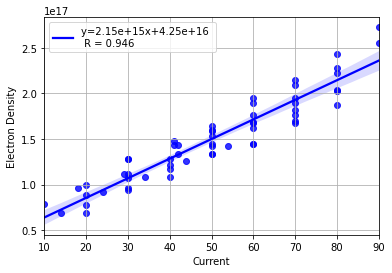

In [21]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Current'], df['Electron Density'])
print(slope, intercept, r_value, p_value, std_err)
# use line_kws to set line label for legend
ax = sns.regplot(x = df['Current'], y = df['Electron Density'], data=df, color='b', 
 line_kws={'label':"y={0:.2e}x+{1:.2e} \n R = {2:.3f}".format(slope,intercept,r_value)})

# plot legend
ax.legend(loc =2)

plt.show()